# Bulk short read RNA-seq analysis with R

This notebook is guided by Chapters 1-5 of [R for Data Science](https://r4ds.had.co.nz/index.html), with a bioinformatics twist. 


## Load packages

In [1]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Import data into R

We have data from 2 patient-derived muscle cell lines, Control and FSHD2, that were differentiated in culture. Bulk short-read RNA-seq was performed using polyA primers and Illumina sequencing. To quantify gene expression, reads were mapped to the human genome using [kallisto](https://pachterlab.github.io/kallisto/about), and the resulting counts matrix was saved as a csv file. The metadata was constructed from the sample names and saved as a csv file.

A variable provides us with a way to store this data and manipulate it. The code below imports the data and assigns it to the`counts` variable, and imports the metadata and assigns it to the `meta` variable. Either `=` or `<-` can be used to assign variables. 


In [6]:
counts = read.csv("data/fshd.counts.matrix.csv")
meta <- read.csv("data/fshd.metadata.csv")

In [3]:
head(counts)
dim(counts)

,Gene_ID,Gene_Name,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000223972.5,DDX11L1,0,2,0,0,0,0,0,0
2,ENSG00000227232.5,WASH7P,6,20,6,13,9,6,0,14
3,ENSG00000278267.1,MIR6859-1,0,0,0,0,0,0,0,0
4,ENSG00000243485.5,MIR1302-2HG,0,0,0,0,0,0,0,0
5,ENSG00000284332.1,MIR1302-2,0,0,0,0,0,0,0,0
6,ENSG00000237613.2,FAM138A,0,0,1,0,3,0,0,4


[1] 59429    10

In [4]:
head(meta)
dim(meta)

,Sample,Patient,Day,Rep
,<chr>,<chr>,<int>,<chr>
1,Control_78_Day_0_Rep3,Control,0,Rep3
2,Control_78_Day_0_Rep4,Control,0,Rep4
3,Control_78_Day_3_Rep1,Control,3,Rep1
4,Control_78_Day_3_Rep2,Control,3,Rep2
5,FSHD2_19_Day_0_Rep1,FSHD2,0,Rep1
6,FSHD2_19_Day_0_Rep2,FSHD2,0,Rep2


[1] 8 4

### Questions
1. How many genes are detected?
2. How many samples are there?
3. What is the gene name in the 6th row?
4. How many columns are in the metadata?
5. What are the column names of the metadata?
6. Which days were the samples collected on?

## Data visualization: [creating a ggplot](https://r4ds.had.co.nz/data-visualisation.html#creating-a-ggplot)

Let's start using `ggplot()` by visualizing gene expression between the first 2 samples. First, filter the data to just be the gene ID and samples `Control_78_Day_0_Rep3` and `Control_78_Day_0_Rep4` (columns 1, 3, and 4).

In [5]:
counts_filt = counts[,c(1,3,4)]

In [6]:
head(counts_filt)

,Gene_ID,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4
,<chr>,<int>,<int>
1,ENSG00000223972.5,0,2
2,ENSG00000227232.5,6,20
3,ENSG00000278267.1,0,0
4,ENSG00000243485.5,0,0
5,ENSG00000284332.1,0,0
6,ENSG00000237613.2,0,0


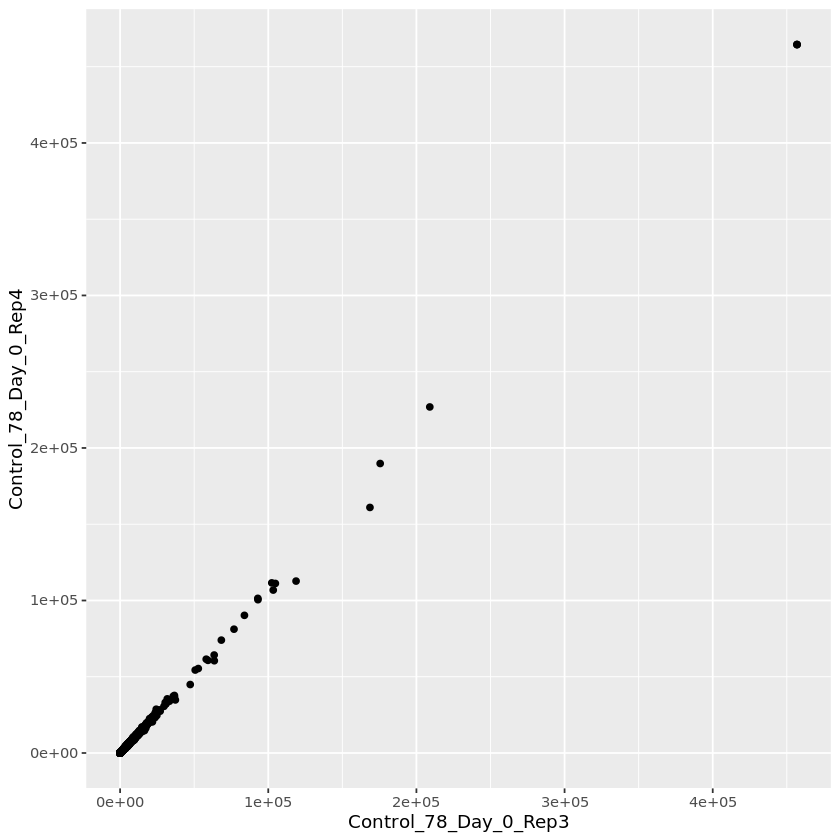

In [7]:
ggplot(data = counts_filt) + 
  geom_point(mapping = aes(x = Control_78_Day_0_Rep3, y = Control_78_Day_0_Rep4))

## Data normalization
We won't get into too much detail yet, but normalization is very important in RNA-seq analysis. A simple log transformation makes the data much easier to visualize and interpret.

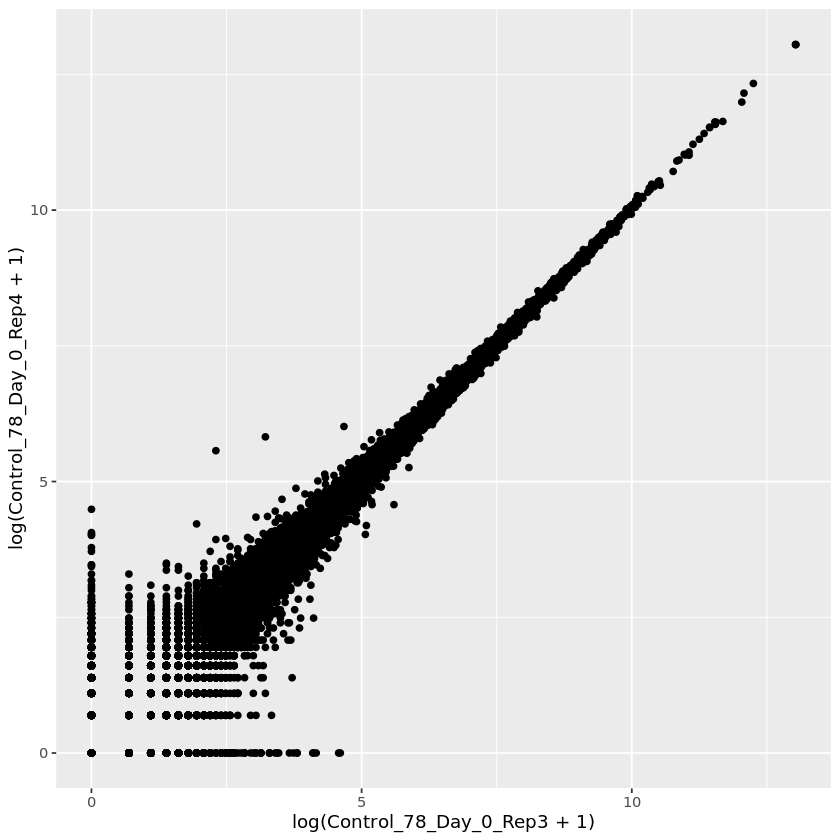

In [8]:
ggplot(data = counts_filt) + 
  geom_point(mapping = aes(x = log(Control_78_Day_0_Rep3 + 1), y = log(Control_78_Day_0_Rep4 + 1))) # add 1 because log(0) is not a number

## Scatter plot interpretation

Each point in this scatterplot (or geom_point plot) is a gene, with its position defined by expression in Control Day 0 replicates. The replicates are positively correlated, suggesting they are doing the same thing. Let's compare a Control Day 0 sample to an FSHD2 sample.

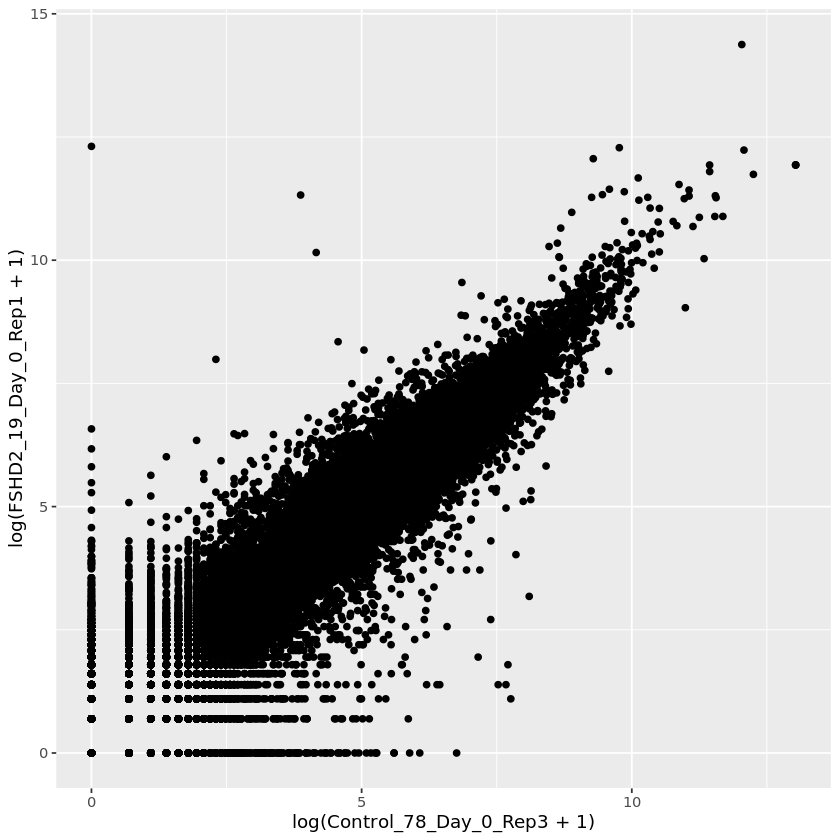

In [9]:
counts_filt2 = counts[,c(1,3,7)]

ggplot(counts_filt2) + 
  geom_point(aes(x = log(Control_78_Day_0_Rep3 + 1), y = log(FSHD2_19_Day_0_Rep1 + 1)))

Overall, the Control Day 0 sample and the FSHD2 Day 0 sample are also overall positively correlated, but you can see that the genes are more spread out with more outliers.

# PCA

We could make dozens of 2D scatterplots comparing each of our 8 samples to each other, or even 3D scatterplots to look at 3 samples at once, or we could use principal component analysis!

[Watch this 5 minute explanation of PCA](https://www.youtube.com/watch?v=HMOI_lkzW08&t=1s)

[Optional: Longer explanation](https://www.youtube.com/watch?v=FgakZw6K1QQ)

Let's return to our full `counts` data frame. We will use the `pca()` function, which requires a matrix as input. 

In [10]:
# reformat data frame to be a numerical matrix (same as before)
mat = counts[,c(3:ncol(counts))] # remove gene ID and gene name columns 1 and 2 because they are not numerical
rownames(mat) = counts$Gene_ID

In [11]:
# run PCA algorithm  
pca <- prcomp(t(log2(mat+1)))
#head(pca)
class(pca) # output is its own fancy class

[1] "prcomp"

## Plot PCA results

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Control_78_Day_0_Rep3,-58.60336,85.55972,-53.352606,16.13173,-22.47057,11.492455,71.120309,2.759356e-12
Control_78_Day_0_Rep4,-59.33674,82.53492,-50.523567,10.80118,-25.09732,-9.166905,-73.117266,1.700685e-12
Control_78_Day_3_Rep1,109.30718,57.45766,21.440230,24.36630,71.56387,52.749335,-8.078537,7.924857e-13
Control_78_Day_3_Rep2,117.61277,59.52040,76.654983,-21.64262,-37.68820,-51.552908,7.617348,6.162543e-13
FSHD2_19_Day_0_Rep1,-138.36024,-63.44100,81.538592,47.49279,-22.20764,26.891298,-2.889610,1.573727e-12
FSHD2_19_Day_0_Rep2,-116.20559,-20.76425,3.949096,-74.23032,61.86991,-31.997648,5.007007,3.001900e-13


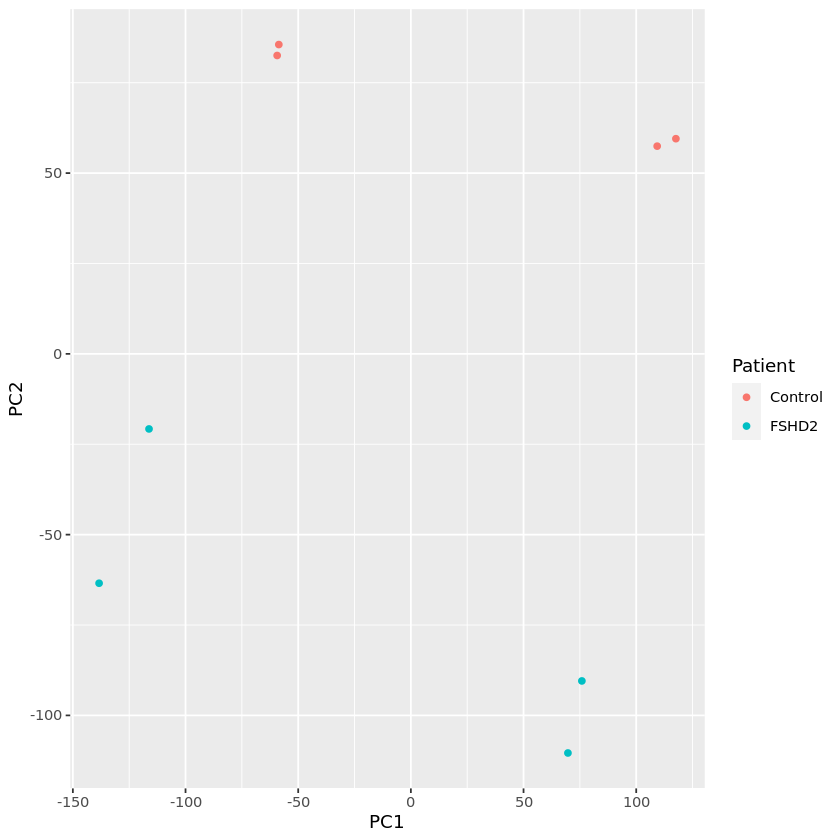

In [12]:
# Grab pca output, stored in "x"
pca_out <- pca$x
head(pca_out) # a matrix with the same number of PCs as samples

pca_out = cbind(pca_out, meta)

ggplot(pca_out)+
  geom_point(aes(x=PC1,y=PC2,color=Patient)) # adding color for Patient

## PCA results visualization: [aesthetic mappings](https://r4ds.had.co.nz/data-visualisation.html#aesthetic-mappings)

Introducing a lot of customization! Try changing the colors or sizes, or replace `theme_bw()` with another theme such as `theme_void()` or `theme_classic()`.

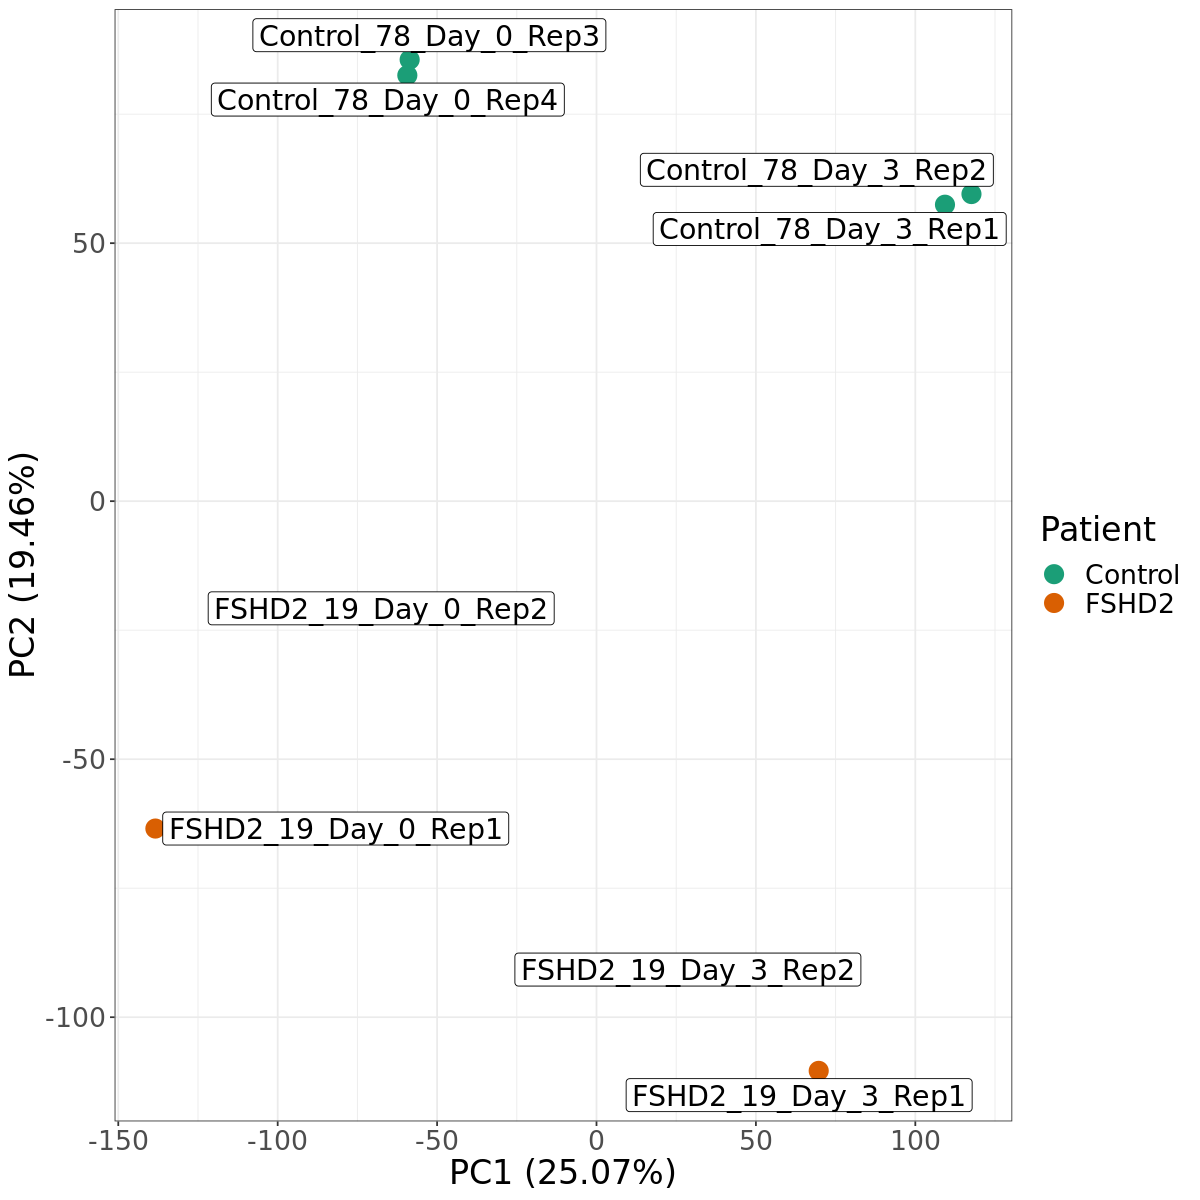

In [13]:
library(ggrepel) # need another package

# Get percent variance explained for x and y axes
percentage <- round(pca$sdev/sum(pca$sdev) * 100, 2)
percentage <- paste0(colnames(pca_out)[1:length(percentage)], " (", paste0(as.character(percentage), "%", ")"))

options(repr.plot.width=10, repr.plot.height=10) # notebook options to display plots with specified dimensions

ggplot(pca_out)+
    geom_point(aes(x=PC1, y=PC2, color=Patient), 
               size=5) +  # increase size of all points outside the aes() function
    xlab(percentage[1]) + ylab(percentage[2]) + # add x and y labels
    geom_label_repel(aes(x=PC1,y=PC2,label = Sample), size = 6) + # label points by Sample using ggrepel library
    theme_bw() + # ggplot comes with pre-configured themes https://ggplot2.tidyverse.org/reference/ggtheme.html
    scale_color_manual(values=c("#1b9e77", "#d95f02")) + # set custom colors for Control and Patient, can also use common color names like "red" and "blue"
    theme(text = element_text(size=20)) # increase overall font size

## PCA interpretation
PC1 separates Day 0 and Day 3, while PC2 separates FSHD2 from Control. We know that PCs are ranked by importance, so the difference in gene expression between Day 0 and Day 3 of differentiation is actually more important than the difference between gene expression betwen Control and FSHD2 cells. 

The percentage indicates the percent of variance in the dataset "explained" by the principal component, decreasing from PC1 to the last PC. The sum of all the percents = 100.

# Differential expression analysis

We can statistically test for differential gene expression. We will go over this in more detail later. For now, let's look at the results from comparing control Day 0 to control Day 3. Each gene has a logFC or log fold change and Pvalue. Positive logFC means the gene was expressed higher or "upregulated" in the Day 3 cells compared to Day 0, while negative logFC means the gene was expressed lower or "downregulated" in the Day 3 cells compared to Day 0.

In [16]:
de = read.csv("results/control_day0_day3_de_results.csv")

## Format results

Why did we use gene IDs rather than gene names to make our matrix? Unfortunately, there are some duplicate gene names but not gene IDs. We can get the gene names back by merging the differential expression results table with the original counts matrix. See [this page](https://dplyr.tidyverse.org/reference/mutate-joins.html) for more infomation on joining logic in dplyr.

In [17]:
plot_table = left_join(de, counts, by = "Gene_ID")

table(duplicated(plot_table$Gene_Name)) 
table(duplicated(plot_table$Gene_ID))


FALSE  TRUE 
16109    36 


FALSE 
16145 

## [Data transformation](https://r4ds.had.co.nz/transform.html#transform)
Categorize each gene as upregulated, downregulated, or no change based on chosen cutoffs |logFC|> 1, Pvalue < 0.01 using [mutate](https://r4ds.had.co.nz/transform.html#add-new-variables-with-mutate) and [logical operators](https://r4ds.had.co.nz/transform.html#logical-operators). `ifelse()` is a base R function. If the gene's logFC >= 2.0 & PValue <  0.01 then it is assigned to be Upregulated category. If not, it is compared to logFC<= -2.0 & PValue <  0.01 and either assigned to Downregulated if these conditions are true, or else No Change.

In [18]:
plot_table <- mutate(plot_table, 
                     Categories = ifelse(logFC >= 2.0 & PValue <  0.01,"Upregulated on day 3", 
                                         ifelse(logFC<= -2.0 & PValue <  0.01 , "Downregulated on day 3", "No Change")))

head(plot_table)

,logFC,logCPM,F,PValue,Gene_ID,Gene_Name,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2,Categories
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,-0.4775390,-0.4136304,0.2521153,0.629506927,ENSG00000227232.5,WASH7P,6,20,6,13,9,6,0,14,No Change
2,0.2206432,0.7533316,0.1864380,0.677629251,ENSG00000233750.3,CICP27,24,20,27,24,37,15,19,17,No Change
3,0.4413614,0.6095683,0.9475596,0.359667869,ENSG00000241860.6,AL627309.5,12,12,9,25,21,29,25,32,No Change
4,0.4380888,2.4181646,0.4691568,0.513286203,ENSG00000279457.4,FO538757.1,96,77,121,110,18,85,75,33,No Change
5,1.8896203,1.6286391,15.5250199,0.004551178,ENSG00000228463.10,AP006222.1,25,10,39,99,26,33,58,63,No Change
6,-0.3343205,1.0974945,0.4555211,0.519299517,ENSG00000237094.12,AL732372.2,33,21,26,16,33,49,23,35,No Change


In [19]:
table(plot_table$Categories) # how many DE genes?


Downregulated on day 3              No Change   Upregulated on day 3 
                   441                  14674                   1030 

## Plot differential expression results
[Filter](https://r4ds.had.co.nz/transform.html#filter-rows-with-filter) the results within `geom_label_repel()` to label the most significant differentially expressed genes .

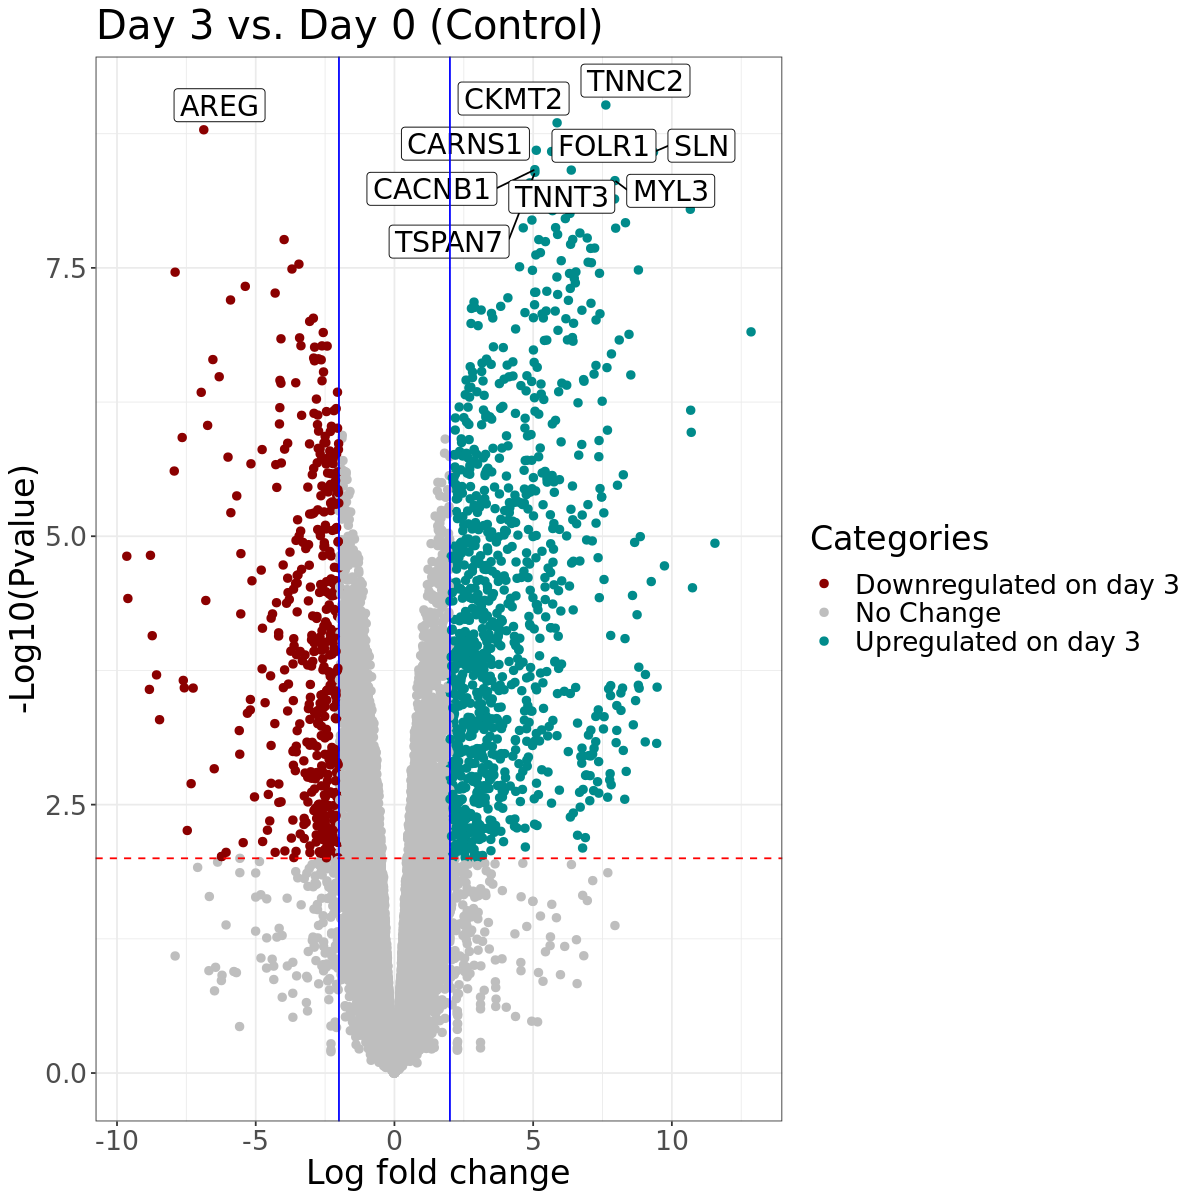

In [21]:
library(ggrepel)

options(repr.plot.width=10, repr.plot.height=10) 

ggplot(plot_table)+
    geom_point(aes(x=logFC, y=-log10(PValue), color=Categories), 
               size=2) + 
    xlab("Log fold change") + ylab("-Log10(Pvalue)") + 
    geom_label_repel(data = head(arrange(plot_table, PValue),10), # plot top DE genes
                     aes(x=logFC,y=-log10(PValue),label = Gene_Name), size = 6, max.overlaps = 150) +
    theme_bw() +
    scale_color_manual(values=c("darkred", "grey", "darkcyan")) +
    theme(text = element_text(size=20)) +
    geom_hline(yintercept=2, linetype="dashed", # add vertical and horizontal lines to indicate significance cutoffs
             color = "red", size=0.5) +
    geom_vline(xintercept=2, color = "blue", size=0.5) +
    geom_vline(xintercept=-2, color = "blue", size=0.5) +
    ggtitle("Day 3 vs. Day 0 (Control)")


## Volcano plot interpretation and best practices

- DE statisical results are log-transformed and visualized with a volcano scatterplot
- Each point is a gene plotted by log fold change on the x-axis and -log10(Pvalue) on the y-axis
- P values are converted so that genes higher up on the y-axis are more statistically significant
- Fold change indicates the number of times more/less a gene is expressed
- There is always a comparison in DE testing such as Day 3 vs. Day 0, or Control vs. Treated
- Labels should clearly indicate the comparison
- Statistical cutoffs are arbitrary; if few genes are DE, relax thresholds (for example |logFC| >= 0.5 / logFC<= -0.5 and Pvalue < 0.05)
- With more complicated DE test designs we can compare conditions like disease state while also accounting for other conditons like timepoint

# Heatmaps and dendrograms

There are several heatmap packages, we'll be using [ComplexHeatmap](https://jokergoo.github.io/ComplexHeatmap-reference/book/).

In [25]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [22]:
# Input to ComplexHeatmap must be a matrix
table_hm = plot_table[plot_table$Categories == "Upregulated on day 3",]
rn = table_hm$Gene_Name
table_hm = as.matrix(table_hm[,colnames(plot_table) %in% meta$Sample])

rownames(table_hm) = rn
# Scale rows between 0 and 1 
table_hm =t(apply(table_hm, 1, function(x)(x-min(x))/(max(x)-min(x))))
table_hm[is.na(table_hm)] = 0
                       

In [23]:
head(table_hm)

,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2
HES4,0.00000000,0.000000000,0.10144928,0.28985507,0.02898551,0.00000000,0.6811594,1.0000000
AGRN,0.03041825,0.000000000,0.16730038,0.25475285,0.11406844,0.14448669,0.7110266,1.0000000
CFAP74,0.07692308,0.000000000,0.92307692,1.00000000,0.53846154,0.23076923,0.4615385,0.7692308
PLCH2,0.00000000,0.000000000,0.04411765,0.08823529,0.10294118,0.08823529,1.0000000,0.9852941
MEGF6,0.01587302,0.000000000,0.11111111,0.09523810,0.19841270,0.12698413,1.0000000,0.7619048
HES2,0.04166667,0.008333333,0.64166667,1.00000000,0.04166667,0.00000000,0.3166667,0.3916667


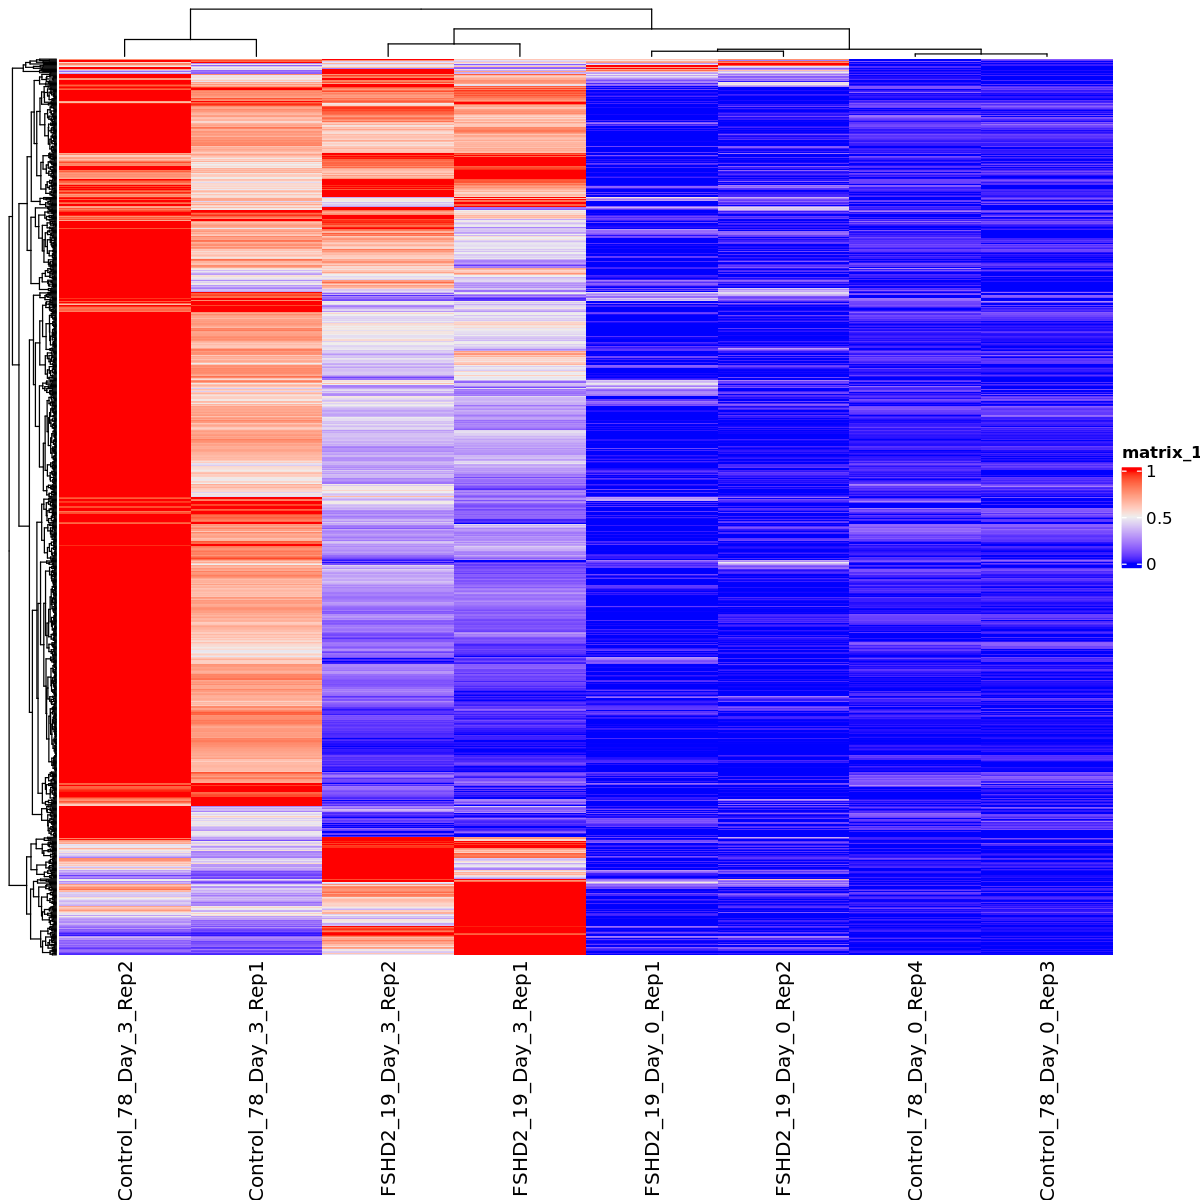

In [26]:
Heatmap(table_hm, show_row_names = FALSE)

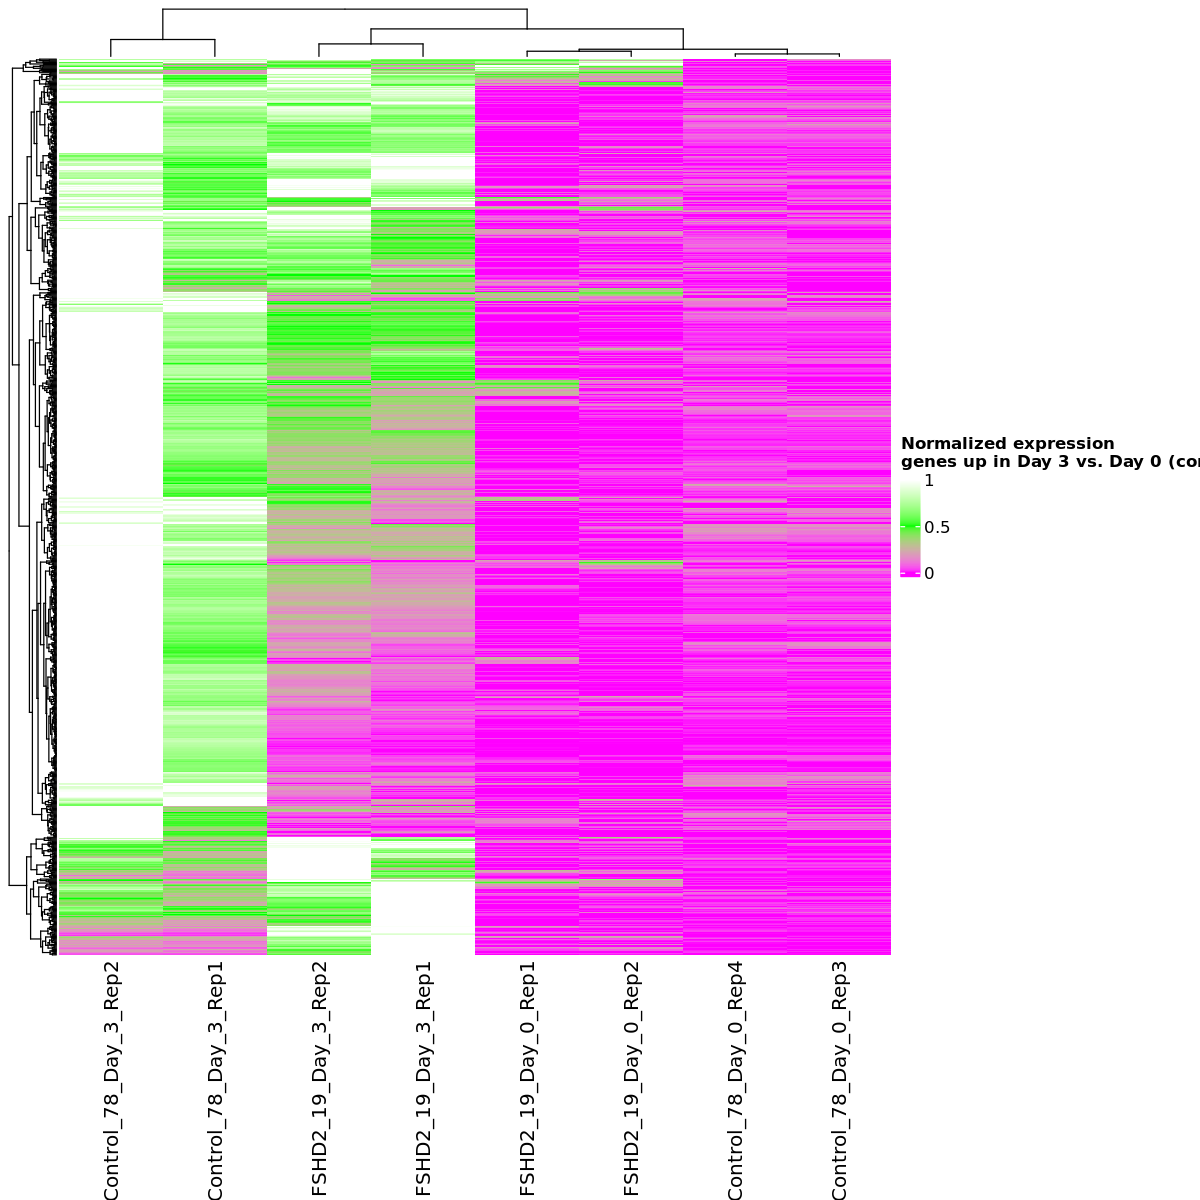

In [28]:
# Play with colors

library(circlize)
col_fun = colorRamp2(c(0, 0.5,1), c("magenta", "green", "white"))

library(viridis)
Heatmap(table_hm, name = "Normalized expression\ngenes up in Day 3 vs. Day 0 (control)", 
        show_row_names = FALSE, col = col_fun)

## Heatmap interpretation and best practices

- Use colorblind friendly palettes like viridis
- Ideally use normalized data such as TPM (transcripts-per-million) rather than log-normalized counts
- Scale from 0 to 1 within each gene (row)
- Ask yourself if the sample (column) clustering makes sense (are there any outliers?)
- Both large (>1,000 genes) and small (< 10 genes) heatmaps can be useful

## Add heatmap annotation

In [72]:
#Set annotation
ann = meta[,2:ncol(meta)] # remove "Sample" column, just keep the columns we want annotations for
head(ann)


,Patient,Day,Rep
,<chr>,<int>,<chr>
1,Control,0,Rep3
2,Control,0,Rep4
3,Control,3,Rep1
4,Control,3,Rep2
5,FSHD2,0,Rep1
6,FSHD2,0,Rep2


In [60]:
colors <- list("Patient" = c("Control" = "blue", 
                              "FSHD2" = "red"),
               "Day" = c("0" = "limegreen", 
                          "3" = "gold"),
               "Rep" = c("Rep1" = "grey",
                         "Rep2" = "cyan",
                         "Rep3" = "blue",
                         "Rep4" = "green"))

colAnn <- HeatmapAnnotation(df = ann,
                            which = 'col',
                            col = colors)


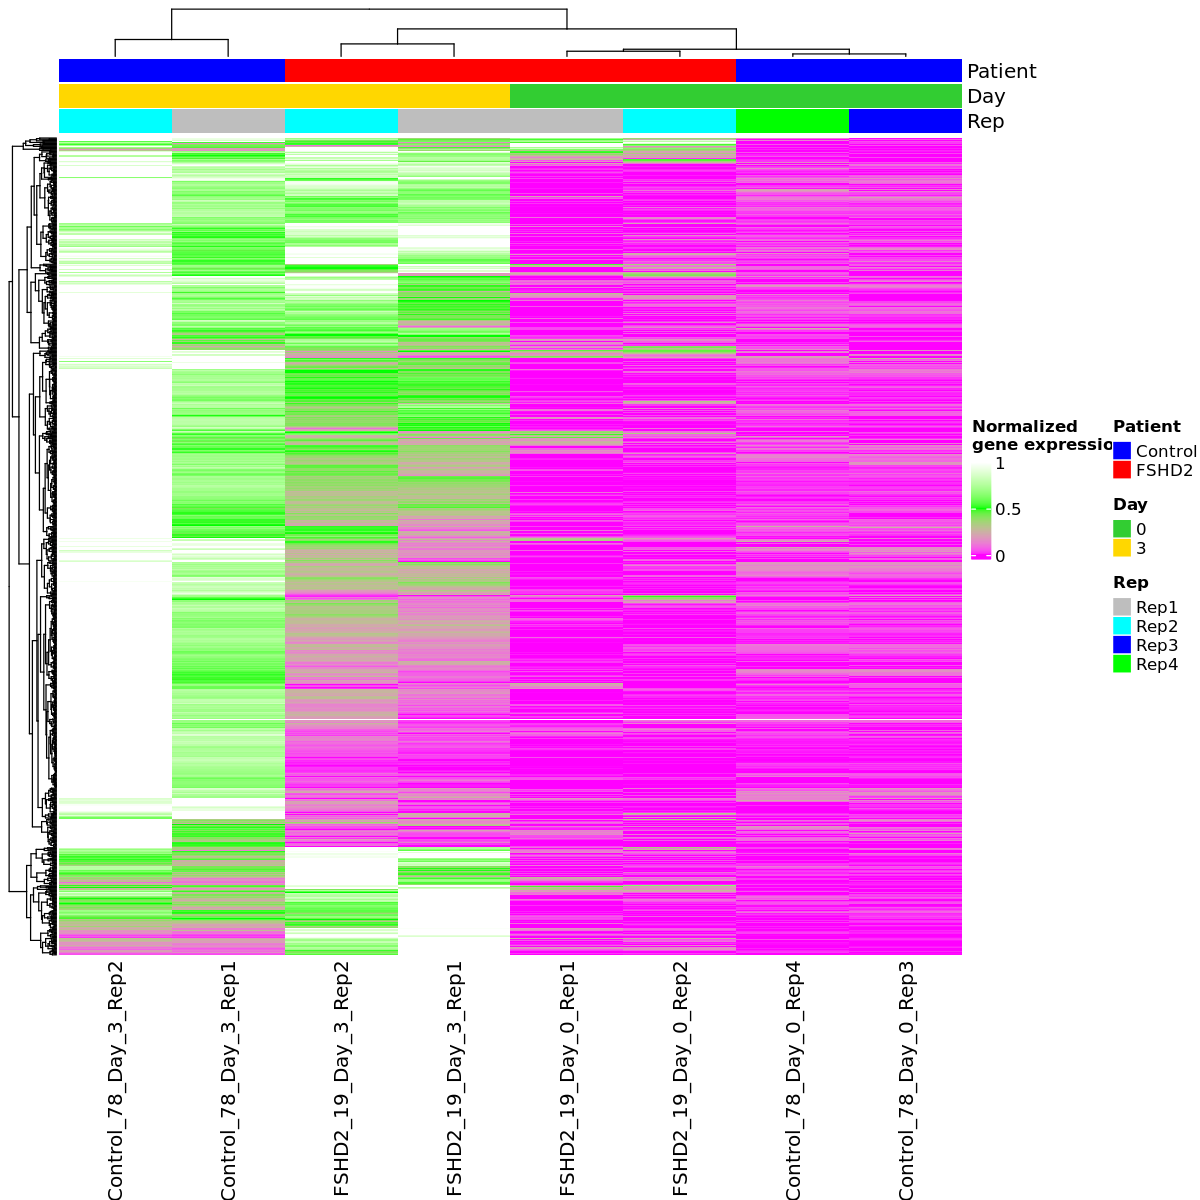

In [66]:
# Play with colors

library(circlize)
col_fun = colorRamp2(c(0, 0.5,1), c("magenta", "green", "white"))

library(viridis)
Heatmap(table_hm, name = "Normalized\ngene expression", 
        show_row_names = FALSE, 
        top_annotation=colAnn,
        col = col_fun)



## Fix legends to all be on one side

In [70]:
# save heatmap as a variable "hmap"
hmap = Heatmap(table_hm, name = "Normalized\ngene expression", 
        show_row_names = FALSE, 
        top_annotation=colAnn,
        col = col_fun)


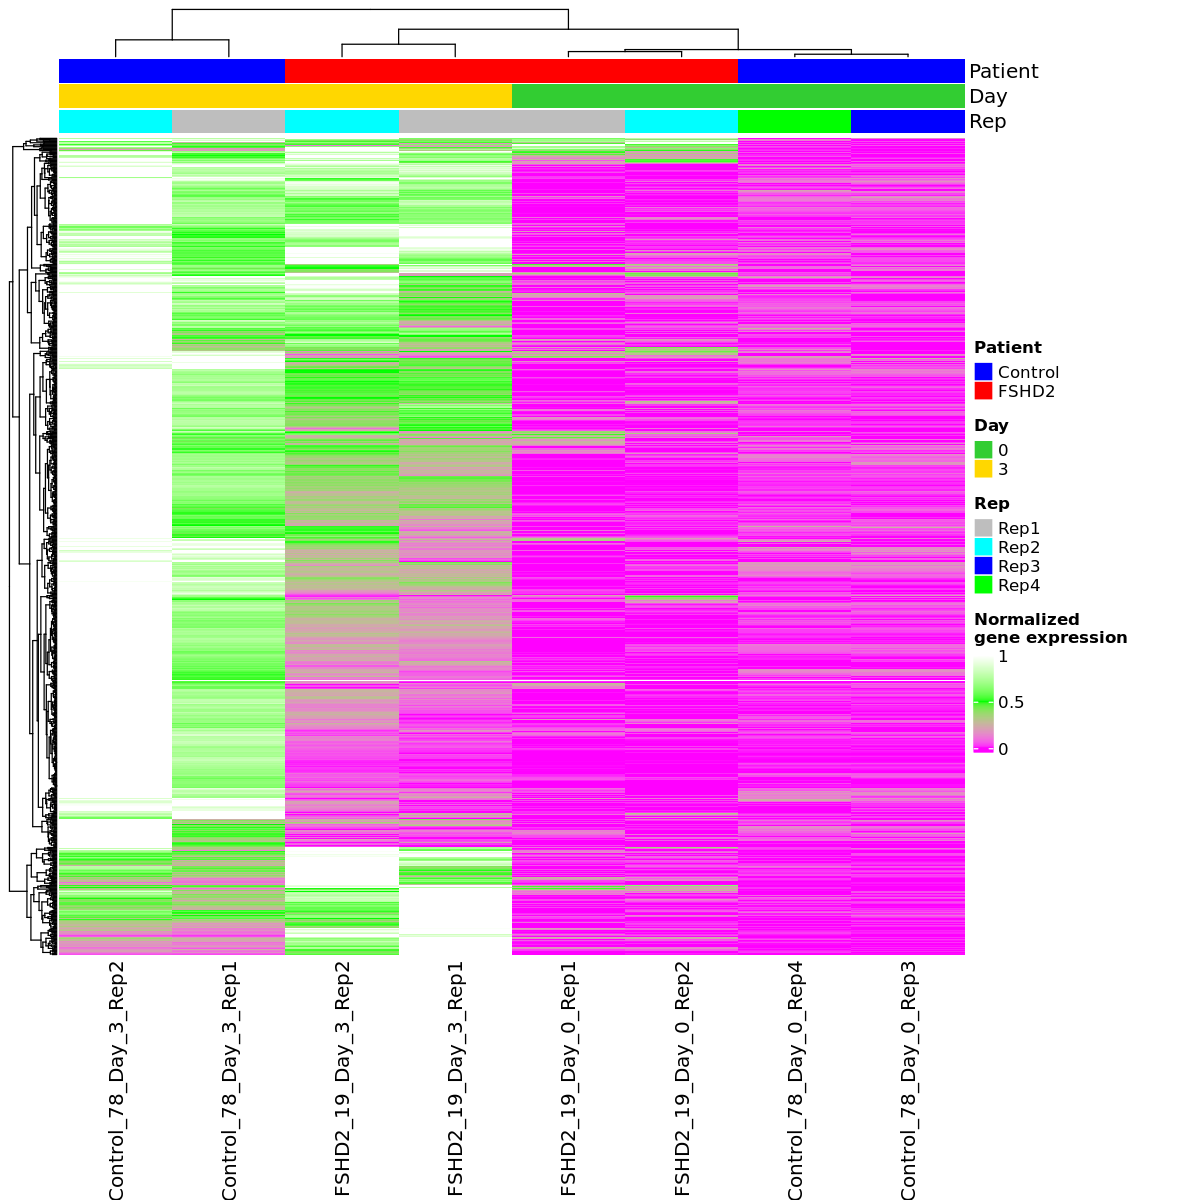

In [71]:
draw(hmap, merge_legend = TRUE, padding = unit(c(2, 2, 2, 20), "mm")) # use options in "draw" function 